<a href="https://colab.research.google.com/github/Sampath-Varma/Sampath_INFO5731_Fall2024/blob/main/Byrraju_Sampath_Exercise_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
import gensim
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Define a function to read the txt file
def load_txt_data(filepath):
    labels = []
    reviews = []
    with open(filepath, 'r') as file:
        for line in file:
            label = int(line[0])
            review = line[2:].strip()
            labels.append(label)
            reviews.append(review)
    return pd.DataFrame({'sentiment': labels, 'review': reviews})

# Load the train and test data
train_data = load_txt_data("/content/stsa-train.txt")
test_data = load_txt_data("/content/stsa-test.txt")

# Define feature (X) and target (y) variables for train and test sets
X_train_data = train_data['review']
y_train_data = train_data['sentiment']
X_test_data = test_data['review']
y_test_data = test_data['sentiment']

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)

# Function to generate Word2Vec embeddings
def get_word2vec_embeddings(text_data):
    tokenized_text = [text.split() for text in text_data]
    model = gensim.models.Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
    embeddings = np.array([np.mean([model.wv[word] for word in words if word in model.wv]
                                   or [np.zeros(100)], axis=0) for words in tokenized_text])
    return embeddings

# Function to generate BERT embeddings
def get_bert_embeddings(text_data):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    embeddings = []
    for text in text_data:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
        embeddings.append(cls_embedding.flatten())
    return np.array(embeddings)

# List of classifiers to try
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

# Dictionary to store results
results = {}

# Set up cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop over classifiers
for clf_name, clf in classifiers.items():
    pipeline = Pipeline([
        ('vect', CountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('clf', clf),
    ])

    # Perform 10-fold cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    pipeline.fit(X_train, y_train)

    # Evaluate on validation data
    y_val_pred = pipeline.predict(X_val)

    # Calculate metrics
    accuracy = metrics.accuracy_score(y_val, y_val_pred)
    precision = metrics.precision_score(y_val, y_val_pred, average='binary')
    recall = metrics.recall_score(y_val, y_val_pred, average='binary')
    f1 = metrics.f1_score(y_val, y_val_pred, average='binary')

    # Store results
    results[clf_name] = {
        'Cross-Validation Accuracy': cv_scores.mean(),
        'Validation Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Word2Vec Embeddings
word2vec_embeddings_train = get_word2vec_embeddings(X_train)
word2vec_embeddings_val = get_word2vec_embeddings(X_val)

# Train a classifier using Word2Vec embeddings
word2vec_clf = SVC(kernel='linear')
word2vec_clf.fit(word2vec_embeddings_train, y_train)
y_val_pred_w2v = word2vec_clf.predict(word2vec_embeddings_val)
results['Word2Vec_SVM'] = {
    'Validation Accuracy': metrics.accuracy_score(y_val, y_val_pred_w2v),
    'Precision': metrics.precision_score(y_val, y_val_pred_w2v),
    'Recall': metrics.recall_score(y_val, y_val_pred_w2v),
    'F1 Score': metrics.f1_score(y_val, y_val_pred_w2v)
}

# BERT Embeddings
bert_embeddings_train = get_bert_embeddings(X_train)
bert_embeddings_val = get_bert_embeddings(X_val)

# Train a classifier using BERT embeddings
bert_clf = SVC(kernel='linear')
bert_clf.fit(bert_embeddings_train, y_train)
y_val_pred_bert = bert_clf.predict(bert_embeddings_val)
results['BERT_SVM'] = {
    'Validation Accuracy': metrics.accuracy_score(y_val, y_val_pred_bert),
    'Precision': metrics.precision_score(y_val, y_val_pred_bert),
    'Recall': metrics.recall_score(y_val, y_val_pred_bert),
    'F1 Score': metrics.f1_score(y_val, y_val_pred_bert)
}

# Print out results for each classifier
for clf_name, metrics in results.items():
    print(f"\nClassifier: {clf_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")



Classifier: MultinomialNB
Cross-Validation Accuracy: 0.7666
Validation Accuracy: 0.7782
Precision: 0.7355
Recall: 0.8892
F1 Score: 0.8051

Classifier: SVM
Cross-Validation Accuracy: 0.7581
Validation Accuracy: 0.7919
Precision: 0.7792
Recall: 0.8317
F1 Score: 0.8046

Classifier: KNN
Cross-Validation Accuracy: 0.5233
Validation Accuracy: 0.4964
Precision: 0.5089
Recall: 0.6381
F1 Score: 0.5663

Classifier: DecisionTree
Cross-Validation Accuracy: 0.6340
Validation Accuracy: 0.6546
Precision: 0.6428
Recall: 0.7419
F1 Score: 0.6888

Classifier: RandomForest
Cross-Validation Accuracy: 0.7144
Validation Accuracy: 0.7399
Precision: 0.7182
Recall: 0.8149
F1 Score: 0.7635

Classifier: XGBoost
Cross-Validation Accuracy: 0.6783
Validation Accuracy: 0.6944
Precision: 0.6586
Recall: 0.8443
F1 Score: 0.7400

Classifier: Word2Vec_SVM
Validation Accuracy: 0.4762
Precision: 0.4630
Recall: 0.1052
F1 Score: 0.1714

Classifier: BERT_SVM
Validation Accuracy: 0.8533
Precision: 0.8512
Recall: 0.8668
F1 Scor

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

KMeans Silhouette Score: 0.0227


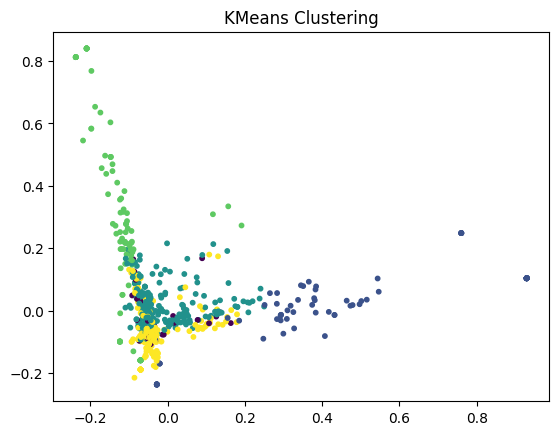

DBSCAN Silhouette Score: 0.0306


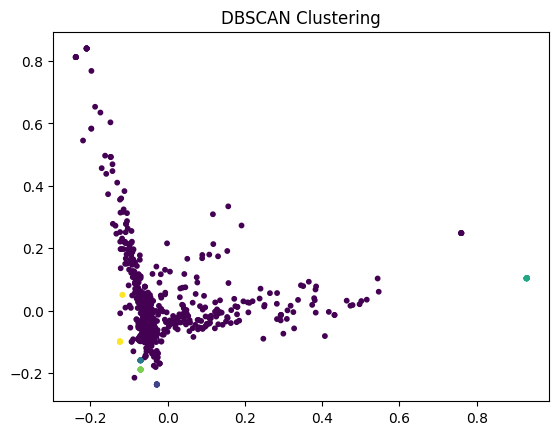

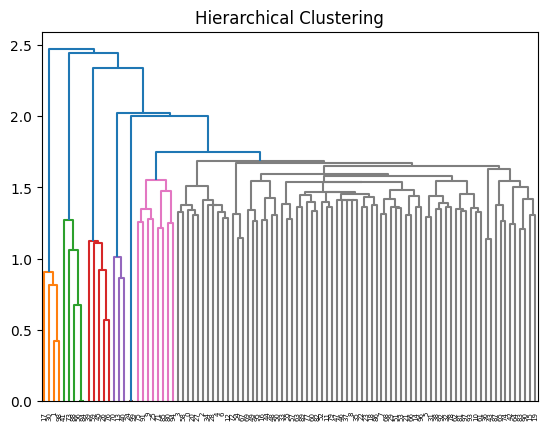

KMeans (Word2Vec) Silhouette Score: 0.5370


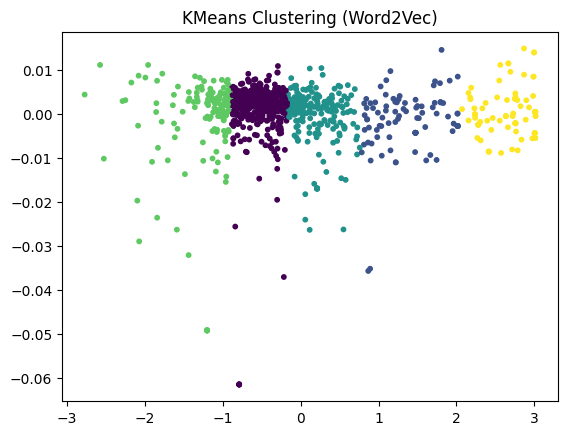

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

KMeans (BERT) Silhouette Score: 0.0474


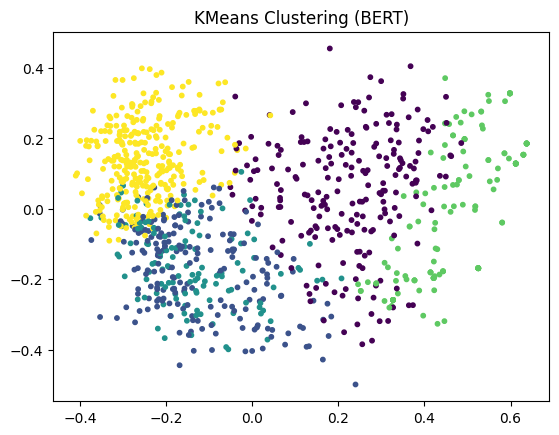

In [6]:
# Write your code here
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

#Load and preprocess the dataset
df = pd.read_csv("Amazon_Unlocked_Mobile.csv")
df = df.dropna(subset=['Reviews'])
df = df.sample(1000, random_state=42)

#Feature extraction (TF-IDF Vectorizer)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['Reviews']).toarray()

#Apply KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)
print(f"KMeans Silhouette Score: {silhouette_score(X_tfidf, kmeans_labels):.4f}")

#Visualize KMeans clusters
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_tfidf)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title('KMeans Clustering')
plt.show()

#Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_tfidf)

#Handle -1 (noise) clusters in Silhouette Score
if len(set(dbscan_labels)) > 1:
    silhouette = silhouette_score(X_tfidf, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {silhouette:.4f}")
else:
    print("DBSCAN did not form distinct clusters.")

#Visualize DBSCAN clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title('DBSCAN Clustering')
plt.show()

#Apply Hierarchical Clustering
sample_data = X_tfidf[:100]
linkage_matrix = linkage(sample_data, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering')
plt.show()

#Apply Word2Vec
tokenized_reviews = [review.split() for review in df['Reviews']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)
X_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in review if word in word2vec_model.wv]
                                or [np.zeros(100)], axis=0) for review in tokenized_reviews])

#Apply KMeans on Word2Vec features
kmeans_labels_w2v = kmeans.fit_predict(X_word2vec)
print(f"KMeans (Word2Vec) Silhouette Score: {silhouette_score(X_word2vec, kmeans_labels_w2v):.4f}")

#Visualize Word2Vec Clusters
reduced_data_w2v = pca.fit_transform(X_word2vec)
plt.scatter(reduced_data_w2v[:, 0], reduced_data_w2v[:, 1], c=kmeans_labels_w2v, cmap='viridis', s=10)
plt.title('KMeans Clustering (Word2Vec)')
plt.show()

#Apply BERT
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
X_bert = bert_model.encode(df['Reviews'].tolist(), show_progress_bar=True)

#Apply KMeans on BERT features
kmeans_labels_bert = kmeans.fit_predict(X_bert)
print(f"KMeans (BERT) Silhouette Score: {silhouette_score(X_bert, kmeans_labels_bert):.4f}")

#Visualize BERT Clusters
reduced_data_bert = pca.fit_transform(X_bert)
plt.scatter(reduced_data_bert[:, 0], reduced_data_bert[:, 1], c=kmeans_labels_bert, cmap='viridis', s=10)
plt.title('KMeans Clustering (BERT)')
plt.show()

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

The clustering results display unique features for each of the employed approaches. In both Word2Vec and BERT embeddings, K-means effectively creates discrete clusters that show unique groupings. However, as evidenced by its dispersed findings, DBSCAN has trouble handling high-dimensional sparse text data, producing a majority of points in a single cluster and some noise. Although hierarchical clustering offers a thorough dendrogram, it is difficult to visually grasp since it lacks distinct separability in higher dimensions. In low-dimensional space, Word2Vec and K-means create distinct clusters that highlight semantic linkages. More clear and significant cluster separations are displayed by BERT embeddings with K-means, which are excellent at capturing fine semantic details.

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [5]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
In the first question if this assignemnt I had learned how to implemet algorithms such as MultinominalNB, SVM, KNN, Decision tree, Random Forest, XGBoost, Word2Vec and BERT and
evalauting their respective measurements. In the second question i had got to practice different machine learning algorithms for text clustering. The code execution for the first
question took me a long time other than taht everything went smooth.

'''

'\nPlease write you answer here:\nIn the first question if this assignemnt I had learned how to implemet algorithms such as MultinominalNB, SVM, KNN, Decision tree, Random Forest, XGBoost, Word2Vec and BERT and\nevalauting their respective measurements. In the second question i had got to practice different machine learning algorithms for text clustering. The code execution for the first \nquestion took me a long time other than taht everything went smooth.\n\n'